In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data
import os.path as osp
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, AttributedGraphDataset, WebKB, WikipediaNetwork, Actor
import torch_geometric.transforms as T
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Union, Tuple, Optional
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, Size
from tqdm import tqdm
from collections import Counter
from dataset import Facebook100
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch_geometric
from torch_geometric.data import Data
import os.path as osp
import os
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Reddit, AttributedGraphDataset,  WebKB, WikipediaNetwork, Actor
from torch_geometric.nn.conv import sage_conv
import torch_geometric.transforms as T
import torch.nn as nn
# from torch_geometric.nn import SplineConv, GCNConv
from torch_geometric.nn import SplineConv, GATConv, SAGEConv
from torch_sparse.mul import mul
print(torch_geometric.__version__)
import numpy as np
import time
import sys
import logging
from torch.nn.utils import clip_grad_norm_
sys.path.append('./')
sys.path.append('./models')
from dataset import Facebook100
import random
import seaborn as sns
from torch_sparse import coalesce, matmul
import copy
import torch_sparse

2.0.2


In [2]:
import os.path as osp
from typing import Callable, List, Optional

import numpy as np
import torch

from torch_geometric.data import InMemoryDataset, download_url
from torch_geometric.io import read_planetoid_data


class Planetoid(InMemoryDataset):
    r"""The citation network datasets "Cora", "CiteSeer" and "PubMed" from the
    `"Revisiting Semi-Supervised Learning with Graph Embeddings"
    <https://arxiv.org/abs/1603.08861>`_ paper.
    Nodes represent documents and edges represent citation links.
    Training, validation and test splits are given by binary masks.

    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The name of the dataset (:obj:`"Cora"`,
            :obj:`"CiteSeer"`, :obj:`"PubMed"`).
        split (string): The type of dataset split
            (:obj:`"public"`, :obj:`"full"`, :obj:`"geom-gcn"`,
            :obj:`"random"`).
            If set to :obj:`"public"`, the split will be the public fixed split
            from the `"Revisiting Semi-Supervised Learning with Graph
            Embeddings" <https://arxiv.org/abs/1603.08861>`_ paper.
            If set to :obj:`"full"`, all nodes except those in the validation
            and test sets will be used for training (as in the
            `"FastGCN: Fast Learning with Graph Convolutional Networks via
            Importance Sampling" <https://arxiv.org/abs/1801.10247>`_ paper).
            If set to :obj:`"geom-gcn"`, the 10 public fixed splits from the
            `"Geom-GCN: Geometric Graph Convolutional Networks"
            <https://openreview.net/forum?id=S1e2agrFvS>`_ paper are given.
            If set to :obj:`"random"`, train, validation, and test sets will be
            randomly generated, according to :obj:`num_train_per_class`,
            :obj:`num_val` and :obj:`num_test`. (default: :obj:`"public"`)
        num_train_per_class (int, optional): The number of training samples
            per class in case of :obj:`"random"` split. (default: :obj:`20`)
        num_val (int, optional): The number of validation samples in case of
            :obj:`"random"` split. (default: :obj:`500`)
        num_test (int, optional): The number of test samples in case of
            :obj:`"random"` split. (default: :obj:`1000`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)

    Stats:
        .. list-table::
            :widths: 10 10 10 10 10
            :header-rows: 1

            * - Name
              - #nodes
              - #edges
              - #features
              - #classes
            * - Cora
              - 2,708
              - 10,556
              - 1,433
              - 7
            * - CiteSeer
              - 3,327
              - 9,104
              - 3,703
              - 6
            * - PubMed
              - 19,717
              - 88,648
              - 500
              - 3
    """

    url = 'https://github.com/kimiyoung/planetoid/raw/master/data'
    geom_gcn_url = ('https://raw.githubusercontent.com/graphdml-uiuc-jlu/'
                    'geom-gcn/master')

    def __init__(self, root: str, name: str, split: str = "public",
                 num_train_per_class: int = 20, num_val: int = 500,
                 num_test: int = 1000, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        self.name = name

        self.split = split.lower()
        assert self.split in ['public', 'full', 'geom-gcn', 'random']

        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

        if split == 'full':
            data = self.get(0)
            data.train_mask.fill_(True)
            data.train_mask[data.val_mask | data.test_mask] = False
            self.data, self.slices = self.collate([data])

        elif split == 'random':
            data = self.get(0)
            data.train_mask.fill_(False)
            for c in range(self.num_classes):
                idx = (data.y == c).nonzero(as_tuple=False).view(-1)
                idx = idx[torch.randperm(idx.size(0))[:num_train_per_class]]
                data.train_mask[idx] = True

            remaining = (~data.train_mask).nonzero(as_tuple=False).view(-1)
            remaining = remaining[torch.randperm(remaining.size(0))]

            data.val_mask.fill_(False)
            data.val_mask[remaining[:num_val]] = True

            data.test_mask.fill_(False)
            data.test_mask[remaining[num_val:num_val + num_test]] = True

            self.data, self.slices = self.collate([data])

    @property
    def raw_dir(self) -> str:
        if self.split == 'geom-gcn':
            return osp.join(self.root, self.name, 'geom-gcn', 'raw')
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        if self.split == 'geom-gcn':
            return osp.join(self.root, self.name, 'geom-gcn', 'processed')
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> List[str]:
        names = ['x', 'tx', 'allx', 'y', 'ty', 'ally', 'graph', 'test.index']
        return [f'ind.{self.name.lower()}.{name}' for name in names]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        for name in self.raw_file_names:
            download_url(f'{self.url}/{name}', self.raw_dir)
        if self.split == 'geom-gcn':
            for i in range(10):
                url = f'{self.geom_gcn_url}/splits/{self.name.lower()}'
                download_url(f'{url}_split_0.6_0.2_{i}.npz', self.raw_dir)

    def process(self):
        data = read_planetoid_data(self.raw_dir, self.name)

        if self.split == 'geom-gcn':
            train_masks, val_masks, test_masks = [], [], []
            for i in range(10):
                name = f'{self.name.lower()}_split_0.6_0.2_{i}.npz'
                splits = np.load(osp.join(self.raw_dir, name))
                train_masks.append(torch.from_numpy(splits['train_mask']))
                val_masks.append(torch.from_numpy(splits['val_mask']))
                test_masks.append(torch.from_numpy(splits['test_mask']))
            data.train_mask = torch.stack(train_masks, dim=1)
            data.val_mask = torch.stack(val_masks, dim=1)
            data.test_mask = torch.stack(test_masks, dim=1)

        data = data if self.pre_transform is None else self.pre_transform(data)
        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name}()'


In [3]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)


In [4]:
data_split_seed = 0
set_random_seed(data_split_seed)
# Dataset = 'Cora'
# Dataset = 'PubMed'
# Dataset = 'CiteSeer'
Dataset = 'Cornell' # "Cornell", "Texas", "Wisconsin"
# Dataset = 'chameleon' # "chameleon", "crocodile", "squirrel"
# Dataset = 'Actor'
# Dataset = 'Reddit'
# Dataset = 'BlogCataLog'
# Dataset = 'ogbn-products'
# Dataset = 'Simmons81' # 'Simmons81', 'UF21', 'Caltech36', 'Northeastern19', 'Tulane29', 'Hamilton46', 'Howard90', 'GWU54', 'UGA50'
transform = T.Compose([
    T.RandomNodeSplit(num_val=1000, num_test=1500, num_train_per_class=20),
    T.TargetIndegree(),
])
path = osp.join('../data', Dataset)
# dataset = Planetoid(path, Dataset, transform=transform)
# dataset = Planetoid(path, Dataset, split='geom-gcn') # 'geom-gcn'
# dataset = AttributedGraphDataset(path, Dataset)
dataset = WebKB(path, name=Dataset)
# dataset = WikipediaNetwork(path, Dataset)
# dataset = Actor(path)

# dataset = Facebook100(path, Dataset, split='random', \
#     num_val=500, num_test=None, num_train_per_class=200, transform=None, to_onehot=True)

# dataset = Reddit(path)
# dataset = AttributedGraphDataset(path, Dataset, transform=transform)
data = dataset[0]
# dataset = PygNodePropPredDataset(name=Dataset, root=path)
# split_idx = dataset.get_idx_split()
# data = dataset[0]
# data.train_mask = torch.Tensor([False] * data.x.shape[0]).bool()
# data.val_mask = torch.Tensor([False] * data.x.shape[0]).bool()
# data.test_mask = torch.Tensor([False] * data.x.shape[0]).bool()
# data.train_mask[split_idx['train']] = True
# data.val_mask[split_idx['valid']] = True
# data.test_mask[split_idx['test']] = True

print(data)
split_idx = 0
# if Dataset in ["Cornell", "Texas", "Wisconsin", "Actor", "chameleon", "squirrel"]:
if Dataset in ["Cornell", "Texas", "Wisconsin", "Actor", "chameleon", "squirrel", "Cora", "PubMed", "CiteSeer"]:
    data.train_mask = data.train_mask[:, split_idx].bool()
    data.val_mask = data.val_mask[:, split_idx].bool()
    data.test_mask = data.test_mask[:, split_idx].bool()
print(data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum())
print(Counter(data.y.view(-1).numpy()))
# for cls_id in range(dataset.num_classes):
#     mask_cls = data.y == cls_id
#     print(cls_id, (data.train_mask * mask_cls).sum().item())

Data(x=[183, 1703], edge_index=[2, 298], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
tensor(87) tensor(59) tensor(37)
Counter({3: 101, 0: 33, 4: 30, 2: 18, 1: 1})


Mean_degree:1.63, min_degree:0, max_degree:8, std:1.46
$1.63\pm 1.46$


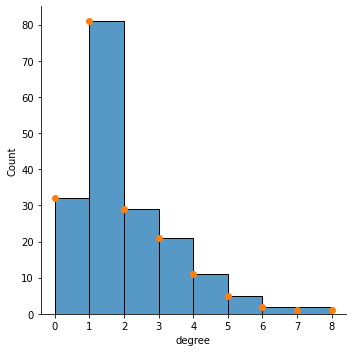

In [5]:
# plot node degree distribution
from torch_geometric.utils import add_self_loops, degree
x, edge_index = data.x, data.edge_index
adj = torch.sparse.LongTensor(data.edge_index.cpu(), torch.ones(data.edge_index.shape[1]), torch.Size((data.x.shape[0], data.x.shape[0])))
# adj
row, col = edge_index
deg = degree(col, x.size(0), dtype=x.dtype)
print('Mean_degree:{:.2f}, min_degree:{}, max_degree:{}, std:{:.2f}'.format(deg.mean(), deg.min().long(), deg.max().long(), deg.std()))
print('${:.2f}\pm {:.2f}$'.format(deg.mean(), deg.std()))
deg = deg[torch.where(deg <= 100)] # degree clip
df_deg = pd.DataFrame({'degree':deg})
sns.displot(df_deg, x='degree', binwidth=1)
from collections import Counter
cnt = Counter()
for d in deg:
    cnt[d.long().item()] += 1
plt.scatter(list(cnt.keys()), list(cnt.values()))
# plt.title('[{}]Mean_degree:{:.2f}, min_degree:{}, max_degree:{}'.format(Dataset, deg.mean(), deg.min().long(), deg.max().long()))
plt.show()

In [6]:
import torch_sparse
from torch_sparse import matmul
x, edge_index = data.x, data.edge_index
row, col = edge_index
deg = degree(col, x.size(0), dtype=x.dtype)
adj_sp = torch_sparse.SparseTensor(row=edge_index[0], col=edge_index[1], value=torch.ones(edge_index.shape[1]).to(edge_index.device), sparse_sizes=(x.shape[0], x.shape[0]))
print(adj_sp)
edge_index_2rd = torch_sparse.matmul(adj_sp, adj_sp.to_dense())
edge_index_2rd = torch.nonzero(edge_index_2rd, as_tuple=False)
edge_index_2rd = edge_index_2rd.transpose(0, 1)
adj_sp_2rd = torch_sparse.SparseTensor(row=edge_index_2rd[0], col=edge_index_2rd[1], value=torch.ones(edge_index_2rd.shape[1]).to(edge_index.device), sparse_sizes=(x.shape[0], x.shape[0]))
print(adj_sp_2rd)
homo_ratio = (data.y[edge_index[0]] == data.y[edge_index[1]]).sum() / edge_index.shape[1]
homo_ratio_2rd = (data.y[edge_index_2rd[0]] == data.y[edge_index_2rd[1]]).sum() / edge_index_2rd.shape[1]
print('homophily ratio:', homo_ratio.item())
print('homophily ratio 2rd neibors:', homo_ratio_2rd.item())

SparseTensor(row=tensor([  1,   3,   4,   4,   4,   4,   4,   4,   4,   5,   6,   7,   7,  10,
                            10,  10,  10,  10,  11,  13,  13,  15,  15,  17,  20,  20,  20,  20,
                            20,  20,  20,  22,  23,  24,  29,  30,  30,  31,  31,  31,  31,  31,
                            31,  31,  31,  32,  33,  37,  37,  37,  38,  38,  41,  41,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,  42,
                            42, 

In [7]:
y_onehot = F.one_hot(data.y)

# x_lbl = y_onehot
x_lbl = torch.zeros_like(y_onehot)
x_lbl[data.train_mask] = y_onehot[data.train_mask]

x_lbl = x_lbl.float()

# label distribution 1st-order
lbl_dist = matmul(adj_sp, x_lbl, reduce='sum')
norm = lbl_dist.norm(p=2, dim=1).view(-1, 1)
norm = torch.matmul(norm, norm.T)
norm[norm == 0] = 1e-8
lbl_sim = torch.matmul(lbl_dist, lbl_dist.T) / norm
print((lbl_sim > 0.99).sum(1).float().mean(), lbl_sim[0])
# label distribution 2rd-order
lbl_dist_2rd = matmul(adj_sp_2rd, x_lbl, reduce='sum')
norm2 = lbl_dist_2rd.norm(p=2, dim=1).view(-1, 1)
norm2 = torch.matmul(norm2, norm2.T) + 1e-8
lbl_sim_2rd = torch.matmul(lbl_dist_2rd, lbl_dist_2rd.T) / norm2
print((lbl_sim_2rd > 0.99).sum(1).float().mean(), lbl_sim_2rd[0])
lbl_sim_merge = lbl_sim * lbl_sim_2rd
print((lbl_sim_merge > 0.99).sum(1).float().mean(), lbl_sim_merge[0])

tensor(5.0383) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.0383) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [8]:
adj_lbl = torch.matmul(x_lbl, x_lbl.T)
# adj_lbl = torch.matmul(y_onehot, y_onehot.T)
adj_lbl -= torch.diag_embed(adj_lbl.diag())
edge_index_lbl = torch.stack(adj_lbl.nonzero(as_tuple=True), dim=0)
print(edge_index_lbl.shape)
print((data.y[edge_index_lbl[0]] == data.y[edge_index_lbl[1]]).sum() / edge_index_lbl.shape[1])

torch.Size([2, 2832])
tensor(1.)


In [9]:
lbl_sim[lbl_sim > 0].min(), lbl_sim[lbl_sim > 0].max(), lbl_sim[lbl_sim > 0].mean(), lbl_sim[(lbl_sim > 0) * (lbl_sim < 0.99)].mean()

(tensor(0.1200), tensor(1.0000), tensor(0.8400), tensor(0.6886))

In [10]:
def train_Sim(data, model, optimizer, clip_grad=False):
    model.train()
    optimizer.zero_grad()
    loss, recons_loss, emb_y_dist_diff = model(data)
    print('recons_loss:{:.4f} | emb_y_dist_diff:{:.4f}'.format(recons_loss.detach().item(), emb_y_dist_diff.detach().item()))
    loss.backward()
    if clip_grad:
        clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2, error_if_nonfinite=True)
    optimizer.step()
    return loss.detach().item()

def finetune_Sim(data, model, optimizer, clip_grad=False):
    model.train()
    optimizer.zero_grad()
    loss = model(data, finetune=True)
    # print('emb_y_dist_diff:{:.4f}'.format( loss.detach().item()))
    loss.backward()
    if clip_grad:
        clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2, error_if_nonfinite=True)
    optimizer.step()
    return loss.detach().item()


def train_AE(data, model, optimizer, clip_grad=False):
    model.train()
    optimizer.zero_grad()
    # loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask])
    x_encode, x_decode = model(data.x)
    # print(x_encode)
    loss = F.mse_loss(data.x, x_decode)
    loss.backward()
    if clip_grad:
        clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2, error_if_nonfinite=True)
    optimizer.step()
    return loss.detach().item()


# @torch.no_grad()
def test_AE(data, model, dataset_name):
    with torch.no_grad():
        model.eval()
        log_probs, accs = model(data), []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            pred = log_probs[mask].max(1)[1]
            acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
            accs.append(acc)
        return accs

In [11]:
# AutoEncoder
class AutoEncoder(nn.Module):
    def __init__(self, in_size, emb_size=64):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, emb_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(emb_size, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, in_size),
            # nn.ReLU(),
        )
        self.reset_parameters()
    def reset_parameters(self):
        for m in self.encoder:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        for m in self.decoder:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [12]:
# Similiar Encoder
from torch_sparse import SparseTensor, set_diag
from torch_geometric.utils import remove_self_loops
class SimEncoder(nn.Module):
    def __init__(self, in_size, emb_size=64):
        super(SimEncoder, self).__init__()

        self.encoder_pre = nn.Sequential(
            nn.Linear(in_size, emb_size),
        )
        # self.encoder_pre = nn.Sequential(
        #     nn.Linear(in_size, 256),
        #     nn.Tanh(),
        #     nn.Linear(256, 128),
        #     nn.Tanh(),
        #     nn.Linear(128, emb_size),
        # )
        
        # self.encoder_post = nn.Sequential(
        #     nn.Linear(emb_size, 256),
        #     nn.Tanh(),
        #     nn.Linear(256, 128),
        # )
        self.encoder_post = nn.Sequential(
            nn.Linear(emb_size, emb_size),
        )
        # self.encoder_post = nn.Sequential(
        #     nn.Linear(in_size, in_size),
        # )
        self.x_sim = None
        self.adj_t_cache = None

        self.lbl_neb_mask = None
        self.lbl_sim = None

        self.reset_parameters()
    def reset_parameters(self):
        for m in self.encoder_pre:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        for m in self.encoder_post:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def moment_calculation(self, adj_t: SparseTensor,
                              x: Tensor,
                              moment: int = 3):
        mu = matmul(adj_t, x, reduce='mean')

        out = [mu]
        if moment > 1:
            if self.use_center_moment:
                sigma = matmul(adj_t, (x - mu).pow(2), reduce='mean')
            else:
                sigma = matmul(adj_t, (x).pow(2), reduce='mean')
            
            sigma[sigma == 0] = 1e-16
            sigma = sigma.sqrt()
            out.append(sigma)

            for order in range(3, moment+1):
                gamma = matmul(adj_t, x.pow(order), reduce='mean')
                mask_neg = None
                if torch.any(gamma == 0):
                    gamma[gamma == 0] = 1e-16
                if torch.any(gamma < 0):
                    mask_neg = gamma < 0
                    gamma[mask_neg] *= -1
                
                gamma = gamma.pow(1/order)
                if mask_neg != None:
                    gamma[mask_neg] *= -1
                out.append(gamma)
        # print(len(out), adj_t)
        return out

    def cal_similarity_batch(self, x, adj_t, batch_src, batch_tar, embedding=False, cat_self=False):
        # x = x - x.mean(dim=0, keepdim=True) # subtract center

        # x_dist = matmul(adj_t, x, reduce='sum')
        # x_dist = torch.cat(self.moment_calculation(adj_t, x_emb, moment=1), dim=-1)
        x_dist = torch.cat(self.moment_calculation(adj_t, x, moment=1), dim=-1)
        if embedding:
            x_dist = self.encoder_post(x_dist)
        
        # concat self
        if cat_self:
            x_dist = torch.cat([x, x_dist], dim=-1)
        # Decentralize
        x_dist -= x_dist.mean(dim=0, keepdim=True)

        x_dist_src = x_dist[batch_src]
        x_dist_tar = x_dist[batch_tar]
        norm1 = x_dist_src.norm(p=2, dim=1).view(-1, 1)
        norm2 = x_dist_tar.norm(p=2, dim=1).view(-1, 1)
        norm = torch.matmul(norm1, norm2.T) + 1e-8
        sim = torch.matmul(x_dist_src, x_dist_tar.T) / norm # n1, n2

        # # dot product
        # sim = torch.matmul(x_dist, x_dist.T)
        return sim
    
    def cal_similarity(self, x, adj_t, embedding=False, cat_self=False):
        # x = x - x.mean(dim=0, keepdim=True) # subtract center

        # x_dist = matmul(adj_t, x, reduce='sum')
        # x_dist = torch.cat(self.moment_calculation(adj_t, x_emb, moment=1), dim=-1)
        x_dist = torch.cat(self.moment_calculation(adj_t, x, moment=1), dim=-1)
        if embedding:
            x_dist = self.encoder_post(x_dist)
        
        # concat self
        if cat_self:
            x_dist = torch.cat([x, x_dist], dim=-1)

        x_dist -= x_dist.mean(dim=0, keepdim=True)
        
        norm = x_dist.norm(p=2, dim=1).view(-1, 1)
        norm = torch.matmul(norm, norm.T) + 1e-8
        sim = torch.matmul(x_dist, x_dist.T) / norm

        # # dot product
        # sim = torch.matmul(x_dist, x_dist.T)
        return sim
    
    def cal_emb_y_distance(self, emb_sim, y_sim, mask):
        # diff = (self.gather(emb_sim, mask, mask) - self.gather(y_sim, mask, mask)).pow(2)
        diff = (emb_sim - self.gather(y_sim, mask, mask, emb_sim.device)).pow(2)
        return diff
    
    def build_mask(self, x, batch_src, batch_tar):
        N = x.shape[0]
        mask1 = torch.zeros((N, 1)).to(x.device)
        mask2 = torch.zeros((N, 1)).to(x.device)
        mask1[batch_src] = 1
        mask2[batch_tar] = 1
        mask = torch.matmul(mask1, mask2.T).bool()
        return mask
    
    def gather(self, mat, idx1, idx2, device=None):
        mat = mat[idx1, :]
        mat = mat[:, idx2]
        if device:
            mat = mat.to(device)
        return mat
    
    def forward(self, data, batch_src=None, batch_tar=None, finetune=False):
        x, edge_index = data.x, data.edge_index
        if batch_src is not None:
            assert batch_tar is not None
            batch_src = batch_src.to(x.device)
            batch_tar = batch_tar.to(x.device)
        if  self.adj_t_cache == None:
            self.adj_t_cache = torch_sparse.SparseTensor(row=edge_index[0], col=edge_index[1], value=torch.ones(edge_index.shape[1]).to(edge_index.device), sparse_sizes=(x.shape[0], x.shape[0]))
        
        if self.lbl_sim is None or self.lbl_neb_mask is None:
            device = x.device
            self.adj_t_cache = self.adj_t_cache.cpu()
            self.prepare_lbl_sim(data.cpu())
            data = data.to(device)
            self.adj_t_cache = self.adj_t_cache.to(device)

            # self.lbl_sim = self.lbl_sim.to(device)
            self.lbl_neb_mask = self.lbl_neb_mask.to(device)
            
        if self.x_sim is None:
            # self.x_sim = self.cal_similarity(x, self.adj_t_cache) # (N, N)
            device = x.device
            self.x_sim = self.cal_similarity(x.cpu(), self.adj_t_cache.cpu()) # (N, N)
            x = x.to(device)
            self.adj_t_cache = self.adj_t_cache.to(device)
            print(self.x_sim.device, self.lbl_sim.device, self.lbl_neb_mask.device)
        
        emb = self.encoder_pre(x)
        # emb = x
        
        # recons_loss = (emb_sim - self.x_sim).pow(2).mean().sqrt()
        if finetune:
            # emb_sim = self.cal_similarity(emb, self.adj_t_cache, embedding=True) # (n1,n2)
            emb_sim = self.cal_similarity_batch(emb, self.adj_t_cache, self.lbl_neb_mask, self.lbl_neb_mask, embedding=True) # (N,N)
            # emb_y_dist_diff = self.cal_emb_y_distance(emb_sim, self.lbl_sim, self.lbl_neb_mask)
            # emb_y_dist_diff = (self.gather(emb_sim, self.lbl_neb_mask, self.lbl_neb_mask) - self.gather(self.lbl_sim, self.lbl_neb_mask, self.lbl_neb_mask)).pow(2)
            emb_y_dist_diff = (emb_sim - self.gather(self.lbl_sim, self.lbl_neb_mask, self.lbl_neb_mask, emb_sim.device)).pow(2)
            loss = (emb_y_dist_diff.sum() / self.lbl_neb_mask.sum().float()).sqrt()
            # loss = (emb_y_dist_diff.sum() / self.lbl_neb_mask.sum().float().sqrt()).sqrt()
        else:
            # emb_sim = self.cal_similarity(emb, self.adj_t_cache, embedding=True) # (N,N)
            # recons_loss = (self.gather(emb_sim, batch_src, batch_tar) - self.gather(self.x_sim, batch_src, batch_tar, x.device)).pow(2)

            emb_sim = self.cal_similarity_batch(emb, self.adj_t_cache, batch_src, batch_tar, embedding=True) # (n1,n2)
            recons_loss = (emb_sim - self.gather(self.x_sim, batch_src, batch_tar, x.device)).pow(2)

            # loss = recons_loss.mean().sqrt() + (emb_y_dist_diff.sum() / self.lbl_neb_mask.sum()).sqrt()
            # loss = (recons_loss + emb_y_dist_diff).mean().sqrt()
            loss = recons_loss.mean().sqrt()
        # return loss, recons_loss.mean().sqrt(), (emb_y_dist_diff.sum() / self.lbl_neb_mask.sum().float().sqrt()).sqrt()
        return loss
        # return loss, recons_loss.mean().sqrt(), torch.zeros(1)

    def get_emb_sim(self, x, embedding=True, cat_self=False):
        emb = self.encoder_pre(x)
        # emb = x
        emb_sim = self.cal_similarity(emb, self.adj_t_cache, embedding=embedding, cat_self=cat_self)
        return emb_sim, emb
    
    def prepare_lbl_sim(self, data, thres_min_deg=3., thres_min_deg_ratio=0.8):
        N = data.num_nodes
        x, edge_index = data.x ,data.edge_index
        # lbl_sim
        edge_index = coalesce(edge_index, None, N, N)[0]
        _, col = edge_index
        mask_src_train = data.train_mask[data.edge_index[0]]
        deg_mask = degree(col[mask_src_train], x.size(0), dtype=x.dtype) # in degree, only count the src nodes in the training set.
        self.lbl_neb_mask = (deg_mask >= thres_min_deg)
        # deg = degree(col, x.size(0), dtype=x.dtype)
        # self.lbl_neb_mask_ratio = (deg_mask.float() / (1e-5 + deg.float())) > thres_min_deg_ratio
        # self.lbl_neb_mask += self.lbl_neb_mask_ratio
        print('candidate set size:', self.lbl_neb_mask.sum())
        # self.lbl_neb_mask = torch.matmul(self.lbl_neb_mask.float().unsqueeze(-1), self.lbl_neb_mask.float().unsqueeze(0)).bool() # (N, N)
        
        y_onehot = F.one_hot(data.y)
        # x_lbl = y_onehot
        x_lbl = torch.zeros_like(y_onehot)
        x_lbl[data.train_mask] = y_onehot[data.train_mask]
        x_lbl = x_lbl.float().to(edge_index.device)

        # label distribution 1st-order
        lbl_dist = matmul(self.adj_t_cache, x_lbl, reduce='sum')
        norm = lbl_dist.norm(p=2, dim=1).view(-1, 1)
        norm = torch.matmul(norm, norm.T) # (N, N)
        norm[norm == 0] = 1e-8
        lbl_sim = torch.matmul(lbl_dist, lbl_dist.T) / norm # (N, N)
        # print((lbl_sim > 0.99).sum(1).float().mean(), lbl_sim[0])
        
        # label distribution 2rd-order
        value = edge_index.new_ones((edge_index.size(1), ), dtype=torch.float)
        edge_index_2nd, value = torch_sparse.spspmm(edge_index, value, edge_index, value, N, N, N)
        value.fill_(0)
        edge_index_2nd, value = remove_self_loops(edge_index_2nd, value)
        adj_sp_2nd = torch_sparse.SparseTensor(row=edge_index_2nd[0], col=edge_index_2nd[1], value=torch.ones(edge_index_2nd.shape[1]).to(edge_index.device), sparse_sizes=(N, N))
        # lbl_dist_2nd = matmul(adj_sp_2rd.to(edge_index.device), x_lbl, reduce='sum')
        lbl_dist_2nd = matmul(adj_sp_2nd, x_lbl, reduce='sum')
        norm2 = lbl_dist_2nd.norm(p=2, dim=1).view(-1, 1)
        norm2 = torch.matmul(norm2, norm2.T) + 1e-8
        lbl_sim_2nd = torch.matmul(lbl_dist_2nd, lbl_dist_2nd.T) / norm2 # (N, N)
        # print((lbl_sim_2nd > 0.99).sum(1).float().mean(), lbl_sim_2nd[0])

        lbl_sim_merge = lbl_sim * lbl_sim_2nd # (N, N)
        # lbl_sim_merge = lbl_sim
        # print((lbl_sim_merge > 0.99).sum(1).float().mean(), lbl_sim_merge[0])
        self.lbl_sim = lbl_sim_merge
        # self.lbl_sim -= torch.diag_embed(self.lbl_sim.diag())

In [13]:
def train_Sim_batch(data, model, optimizer, batch_src, batch_tar, clip_grad=False):
    model.train()
    optimizer.zero_grad()
    loss = model(data, batch_src, batch_tar)
    # print('froward done.', loss.device)
    loss.backward()
    if clip_grad:
        clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2, error_if_nonfinite=True)
    optimizer.step()
    # print('recons_loss:{:.4f} '.format(loss.detach().item()))
    return loss.detach().item()
    


In [14]:
idxs = torch.arange(data.num_nodes)
# bs = data.num_nodes
bs = 10000
src_idx_loader = torch.utils.data.DataLoader(idxs, batch_size=bs, shuffle=False)
tar_idx_loader = torch.utils.data.DataLoader(idxs, batch_size=bs, shuffle=False)

moments1 = []
attentions1 = []
moments2 = []
attentions2 = []


history_val = []
history_test = []
# for model_init_seed in range(10):
for model_init_seed in [0]:
    # model_init_seed = 2
    set_random_seed(model_init_seed)
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    print(device)
    # model = AutoEncoder(in_size=data.x.shape[1], emb_size=64)
    model = SimEncoder(in_size=data.x.shape[1], emb_size=128)
    model = model.to(device)
    data = data.to(device)
    num_epoch = 200

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-3)

    best_acc = {
        'train': 0,
        'val': 0,
        'test': 0
    }

    for epoch in range(1, 1+num_epoch):
        t0 = time.time()
        # loss_train = train_Sim(data, model, optimizer)
        for batch_src in src_idx_loader:
            for batch_tar in tar_idx_loader:
                # print('src:[{}, {}] -> tar:[{}, {}]'.format(batch_src.min(), batch_src.max(), batch_tar.min(), batch_tar.max()))
                loss_train = train_Sim_batch(data, model, optimizer, batch_src, batch_tar)
        # eval_res = test(data, model, dataset_name=Dataset)
        log = 'Epoch: {:03d}, Reconstruction Loss:{:.4f} Time(s/epoch):{:.4f}'.format(epoch, loss_train, time.time() - t0)
        print(log)
    
    print('Begin finetuning...')
    num_epoch_finetune = 30
    for epoch in range(1, 1+num_epoch_finetune):
        t0 = time.time()
        loss_train = finetune_Sim(data, model, optimizer)
        # eval_res = test(data, model, dataset_name=Dataset)
        log = 'Epoch: {:03d}, Supervised Loss:{:.4f} Time(s/epoch):{:.4f}'.format(epoch, loss_train, time.time() - t0)
        print(log)

cuda:2
candidate set size: tensor(9)
cpu cpu cuda:2
Epoch: 001, Reconstruction Loss:0.0846 Time(s/epoch):0.0489
Epoch: 002, Reconstruction Loss:0.0819 Time(s/epoch):0.0073
Epoch: 003, Reconstruction Loss:0.0633 Time(s/epoch):0.0069
Epoch: 004, Reconstruction Loss:0.0596 Time(s/epoch):0.0061
Epoch: 005, Reconstruction Loss:0.0519 Time(s/epoch):0.0071
Epoch: 006, Reconstruction Loss:0.0488 Time(s/epoch):0.0060
Epoch: 007, Reconstruction Loss:0.0460 Time(s/epoch):0.0060
Epoch: 008, Reconstruction Loss:0.0421 Time(s/epoch):0.0061
Epoch: 009, Reconstruction Loss:0.0399 Time(s/epoch):0.0101
Epoch: 010, Reconstruction Loss:0.0381 Time(s/epoch):0.0091
Epoch: 011, Reconstruction Loss:0.0350 Time(s/epoch):0.0090
Epoch: 012, Reconstruction Loss:0.0336 Time(s/epoch):0.0103
Epoch: 013, Reconstruction Loss:0.0327 Time(s/epoch):0.0089
Epoch: 014, Reconstruction Loss:0.0310 Time(s/epoch):0.0091
Epoch: 015, Reconstruction Loss:0.0288 Time(s/epoch):0.0091
Epoch: 016, Reconstruction Loss:0.0274 Time(s/ep

In [15]:
# import functions for model training
import random
import time
import sys
sys.path.append('./models')
from model import *

def train(data, model, optimizer, clip_grad=False):
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.detach().item()


# @torch.no_grad()
def test(data, model, dataset_name):
    with torch.no_grad():
        model.eval()
        log_probs, accs = model(data), []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            pred = log_probs[mask].max(1)[1]
            score = pred.eq(data.y[mask]).sum().item() / mask.sum().item() # acc
            # score = f1_score(data.y[mask].cpu().numpy(), pred.detach().cpu().numpy(), average='micro')
            accs.append(score)
        return accs

def main(data, save=True, repeat=3, num_epoch=200, gnn='GCN'):
    final_acc = {
            'train': [],
            'val': [],
            'test': []
        }
    for train_id in range(1, 1+repeat):
        print('repeat {}/{}'.format(train_id, repeat))
        

        # if Dataset in ["Cornell", "Texas", "Wisconsin", "Actor"]:
        #     data_split_seed = 0
        #     model_init_seed = train_id - 1
        #     # data_split_seed = int((train_id - 1) / 3)
        #     # model_init_seed = int((train_id - 1) % 3)
            
        #     data.train_mask = train_mask[:, data_split_seed]
        #     data.val_mask = val_mask[:, data_split_seed]
        #     data.test_mask = test_mask[:, data_split_seed]
        # else:
        data_split_seed = 0
        model_init_seed = train_id - 1

        set_random_seed(model_init_seed)

        num_layer = 2
        hidden = 64
        if gnn == 'MLP':
            model = MLP(dataset.num_features, dataset.num_classes, hidden=hidden)
        elif gnn == 'GCN':
            model = GCNNet(dataset, num_layer, hidden=hidden)
        elif gnn == 'GAT':
            model = GAT(dataset=dataset, hidden=hidden)
        elif gnn == 'GraphSAGE':
            model = GraphSAGE(dataset, num_layer, hidden=hidden, root_weight=True)
        elif gnn == 'GATv2':
            model = GATv2(in_channels=dataset.num_features, hidden_channels=hidden, out_channels=dataset.num_classes, num_layers=num_layer, heads=1, dropout=0.5, att_dropout=0.5)
        else:
            raise NotImplementedError('Not Implemented Model:{}'.format(gnn))
        # model = myGATv2(in_channels=dataset.num_features, hidden_channels=hidden, out_channels=dataset.num_classes, num_layers=num_layer, heads=1, dropout=0.5, att_dropout=0.5)
        # 
        
        model = model.to(device)
        print(data)
        print(model)

        # data_split_seed = int((train_id - 1) / 3)
        # model_init_seed = int((train_id - 1) % 3)
        # set_random_seed(data_split_seed)
        print('auto fixed data split seed to {}, model init seed to {}'.format(data_split_seed, model_init_seed))

        print(data)
        print('[Dataset-{}] train_num:{}, val_num:{}, test_num:{}, class_num:{}'.format(dataset, data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item(), dataset.num_classes))

        # build optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

        best_acc = {
            'train': 0,
            'val': 0,
            'test': 0
        }

        for epoch in range(1, 1+num_epoch):
            t0 = time.time()
                
            loss_train = train(data, model, optimizer)
            eval_res = test(data, model, dataset_name=Dataset)
            log = 'Epoch: {:03d}, Loss:{:.4f} Train: {:.4f}, Val:{:.4f}, Test: {:.4f}, Time(s/epoch):{:.4f}'.format(epoch, loss_train, *eval_res, time.time() - t0)
            print(log)
            if eval_res[1] > best_acc['val']:
                best_acc['train'] = eval_res[0]
                best_acc['val'] = eval_res[1]
                best_acc['test'] = eval_res[2]
                if save:
                    torch.save(model.state_dict(), '../ckpt/model_best.ckpt')
            
        print('[Run-{} score] {}'.format(train_id, best_acc))
        final_acc['train'].append(best_acc['train'])
        final_acc['val'].append(best_acc['val'])
        final_acc['test'].append(best_acc['test'])
    best_test_run  = np.argmax(final_acc['test'])
    final_acc_avg = {}
    final_acc_std = {}
    for key in final_acc:
        best_acc[key] = max(final_acc[key])
        final_acc_avg[key] = np.mean(final_acc[key])
        final_acc_std[key] = np.std(final_acc[key])
    print('[Average Score] {} '.format(final_acc_avg))
    print('[std Score] {} '.format(final_acc_std))
    print('[Best Score] {}'.format(best_acc))
    print('[Best test run] {}'.format(best_test_run))

In [17]:
main(data, repeat=10, gnn='GraphSAGE')

repeat 1/10
1703
Data(x=[183, 1703], edge_index=[2, 298], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1703, 64)
    (1): SAGEConv(64, 5)
  )
)
auto fixed data split seed to 0, model init seed to 0
Data(x=[183, 1703], edge_index=[2, 298], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
[Dataset-cornell()] train_num:87, val_num:59, test_num:37, class_num:5
Epoch: 001, Loss:1.6388 Train: 0.5747, Val:0.5424, Test: 0.5405, Time(s/epoch):0.0106
Epoch: 002, Loss:1.3816 Train: 0.7471, Val:0.5763, Test: 0.5676, Time(s/epoch):0.0058
Epoch: 003, Loss:0.8669 Train: 0.8391, Val:0.6441, Test: 0.6216, Time(s/epoch):0.0063
Epoch: 004, Loss:0.7809 Train: 0.8621, Val:0.6441, Test: 0.6216, Time(s/epoch):0.0059
Epoch: 005, Loss:0.5954 Train: 0.8736, Val:0.6271, Test: 0.5946, Time(s/epoch):0.0057
Epoch: 006, Loss:0.4538 Train: 0.8621, Val:0.6441, Test: 0.5946, Time(s/epoch):0.0058
Epoch: 007, Loss:0.3461 Train: 0.8851, Val:0.66

Step 1: Adding Edges according to the embedding distribution similairty

In [18]:
with torch.no_grad():
    model.eval()
    loss = model(data, finetune=True)
    print('loss:', loss)
    emb_sim, emb = model.get_emb_sim(data.x, embedding=True, cat_self=True)
print(emb_sim, '\n', model.x_sim)
# with torch.no_grad():
#     model.eval()
#     emb_sim = model.cal_similarity(emb, model.adj_t_cache)
# emb_sim

loss: tensor(1.5301, device='cuda:2')
tensor([[ 1.0000, -0.6522,  0.8471,  ...,  0.2011,  0.6962, -0.1675],
        [-0.6522,  1.0000, -0.8016,  ..., -0.4044, -0.3834, -0.2954],
        [ 0.8471, -0.8016,  1.0000,  ...,  0.3593,  0.6372, -0.0047],
        ...,
        [ 0.2011, -0.4044,  0.3593,  ...,  1.0000,  0.2377, -0.0934],
        [ 0.6962, -0.3834,  0.6372,  ...,  0.2377,  1.0000, -0.4322],
        [-0.1675, -0.2954, -0.0047,  ..., -0.0934, -0.4322,  1.0000]],
       device='cuda:2') 
 tensor([[ 1.0000, -0.4242,  1.0000,  ...,  1.0000,  1.0000, -0.3507],
        [-0.4242,  1.0000, -0.4242,  ..., -0.4242, -0.4242,  0.1019],
        [ 1.0000, -0.4242,  1.0000,  ...,  1.0000,  1.0000, -0.3507],
        ...,
        [ 1.0000, -0.4242,  1.0000,  ...,  1.0000,  1.0000, -0.3507],
        [ 1.0000, -0.4242,  1.0000,  ...,  1.0000,  1.0000, -0.3507],
        [-0.3507,  0.1019, -0.3507,  ..., -0.3507, -0.3507,  1.0000]])


In [19]:
# feat_sim = model.x_sim.cpu()
feat_sim = emb_sim.cpu()
# feat_sim = lbl_sim
feat_sim -= torch.diag_embed(feat_sim.diag())

# # applied mask_node_deg with thres_min_deg
# feat_sim = feat_sim[mask_node_deg, :]
# feat_sim[:, mask_node_deg] = -1

print((feat_sim > 0.99).sum(1).float().mean(), feat_sim[0])
k = 8
# thres_lower_sim = 0.9
thres_lower_sim = np.quantile(feat_sim.view(-1).numpy(), q=1 - 1. * data.num_edges / feat_sim.view(-1).shape[0])
print(thres_lower_sim, data.num_edges)
topk_lbl_sim = feat_sim.topk(k=k, dim=1, largest=True, sorted=False)
# topk_lbl_sim = (lbl_sim_2rd - torch.diag_embed(lbl_sim_2rd.diag())).topk(k=k, dim=1, largest=True, sorted=False)
# topk_lbl_sim = (lbl_sim_merge - torch.diag_embed(lbl_sim_merge.diag())).topk(k=k, dim=1, largest=True, sorted=False)

row = torch.stack([torch.arange(0, x.shape[0]) for _ in range(k)], dim=-1).view(-1).to(x.device)
# row = torch.stack([torch.arange(0, x.shape[0])[mask_node_deg] for _ in range(k)], dim=-1).view(-1).to(x.device)

col = topk_lbl_sim.indices.view(-1)
assert row.shape == col.shape
edge_index_topk_lbl_dist = torch.stack((row, col), dim=0).long()
edge_index_topk_lbl_dist = edge_index_topk_lbl_dist[:, topk_lbl_sim.values.view(-1) >= thres_lower_sim]
edge_index_topk_lbl_dist.shape

# edge_index_topk_lbl_dist = torch.stack(torch.where(lbl_sim > 0.99), dim=0)
# edge_index_topk_lbl_dist.shape

tensor(0.) tensor([ 0.0000, -0.6522,  0.8471, -0.5096, -0.5790, -0.3070, -0.3665, -0.1951,
         0.3516,  0.8546,  0.1503, -0.4982,  0.6841, -0.4554, -0.0525, -0.8415,
        -0.1327, -0.3593,  0.7874,  0.7047, -0.6547,  0.6826, -0.0987, -0.5635,
        -0.5748,  0.7029,  0.5164,  0.2397,  0.8951, -0.7665, -0.0567, -0.2963,
        -0.5354, -0.0861,  0.5230,  0.7764,  0.6880, -0.0567, -0.0791,  0.7379,
        -0.0506, -0.6947, -0.5034,  0.5610,  0.8326, -0.4109,  0.8467, -0.5048,
        -0.0839,  0.7062,  0.6689,  0.3885,  0.6389, -0.4281, -0.6255, -0.1084,
         0.8056,  0.3926, -0.1012,  0.3445, -0.5291, -0.1546,  0.5162,  0.5034,
         0.5811, -0.6351, -0.6238,  0.8023,  0.4786, -0.2399,  0.7212,  0.1593,
         0.1865,  0.5924,  0.3895, -0.0688,  0.5113, -0.5045, -0.0612, -0.5673,
         0.6570, -0.0453, -0.7731,  0.0101, -0.6095,  0.3792,  0.6004,  0.8322,
        -0.5747, -0.5714,  0.2953,  0.7381, -0.1878, -0.4024, -0.2070,  0.6673,
         0.2754,  0.7805,  0.

torch.Size([2, 271])

Step 2: Pruning edges from original graph according to the embedding distributional similarity

In [20]:
# prunning on the original graph
thres_quantile = 0.5
feat_sim = emb_sim.cpu()
mask_prunning = feat_sim[edge_index[0], edge_index[1]]
print('thres:', np.quantile(mask_prunning.cpu().numpy(), q=thres_quantile), mask_prunning.mean())
# mask_prunning = mask_prunning > np.quantile(mask_prunning.cpu().numpy(), q=thres_quantile)
mask_prunning = mask_prunning > 0.
# print(mask_prunning.sum() / mask_prunning.shape[0], '#' * 20)
edge_index_prunning = edge_index[:, mask_prunning]
print('Prune {} edges from {} to {}'.format(mask_prunning.shape[0] - mask_prunning.sum(), edge_index.shape, edge_index_prunning.shape))

thres: -0.08087311312556267 tensor(-0.0823)
Prune 170 edges from torch.Size([2, 298]) to torch.Size([2, 128])


In [21]:
# replace with label-distributional-graph
import copy
from torch_sparse import coalesce
data_modi = copy.deepcopy(data).to(device)
# data_modi.edge_index = edge_index_topk_lbl_dist.to(device)
# data_modi.edge_index = torch.stack((torch.arange(x.shape[0]), torch.arange(x.shape[0])), dim=0).to(device)
# edge_index_merge = coalesce(torch.cat((edge_index, edge_index_topk_lbl_dist), dim=-1), None, data.num_nodes, data.num_nodes)[0]
edge_index_merge = coalesce(torch.cat((edge_index_prunning, edge_index_topk_lbl_dist), dim=-1), None, data.num_nodes, data.num_nodes)[0]

# edge_index_merge = edge_index_lbl.to(device)
# edge_index_merge = coalesce(torch.cat((edge_index, edge_index_lbl), dim=-1), None, data.num_nodes, data.num_nodes)[0]
data_modi.edge_index = edge_index_merge.to(device)
print(data_modi)

Data(x=[183, 1703], edge_index=[2, 395], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])


In [22]:
print('added_edges_ratio_in_train_set:', (data.train_mask[edge_index_topk_lbl_dist[0]] * data.train_mask[edge_index_topk_lbl_dist[1]]).sum().item() / edge_index_topk_lbl_dist.shape[1])
print('added_edges_homo_ratio:', (data.y[edge_index_topk_lbl_dist[0]] == data.y[edge_index_topk_lbl_dist[1]]).sum() / edge_index_topk_lbl_dist.shape[1])

added_edges_ratio_in_train_set: 0.2767527675276753
added_edges_homo_ratio: tensor(0.5240, device='cuda:2')


In [23]:
print((data.y[data.edge_index[0]] == data.y[data.edge_index[1]]).sum() / data.edge_index.shape[1])
print((data.y[data_modi.edge_index[0]] == data.y[data_modi.edge_index[1]]).sum() / data_modi.edge_index.shape[1])

tensor(0.3054, device='cuda:2')
tensor(0.4709, device='cuda:2')


In [34]:
main(data_modi, save=False, repeat=10, gnn='GraphSAGE')

repeat 1/10
1703
Data(x=[183, 1703], edge_index=[2, 395], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1703, 64)
    (1): SAGEConv(64, 5)
  )
)
auto fixed data split seed to 0, model init seed to 0
Data(x=[183, 1703], edge_index=[2, 395], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
[Dataset-cornell()] train_num:87, val_num:59, test_num:37, class_num:5
Epoch: 001, Loss:1.6014 Train: 0.5632, Val:0.5424, Test: 0.5405, Time(s/epoch):0.0071
Epoch: 002, Loss:1.1475 Train: 0.7816, Val:0.6780, Test: 0.5405, Time(s/epoch):0.0058
Epoch: 003, Loss:0.7705 Train: 0.8161, Val:0.7119, Test: 0.5405, Time(s/epoch):0.0058
Epoch: 004, Loss:0.5895 Train: 0.8621, Val:0.7288, Test: 0.5676, Time(s/epoch):0.0057
Epoch: 005, Loss:0.4706 Train: 0.8851, Val:0.7119, Test: 0.5946, Time(s/epoch):0.0058
Epoch: 006, Loss:0.3655 Train: 0.9310, Val:0.6949, Test: 0.6486, Time(s/epoch):0.0061
Epoch: 007, Loss:0.2285 Train: 0.9655, Val:0.71

In [92]:
from models.model import *
num_layer = 2
hidden = 64
# model = MLP(dataset.num_features, dataset.num_classes, hidden=hidden)
model = GCNNet(dataset, num_layer, hidden=hidden)
# model = GATv2(in_channels=dataset.num_features, hidden_channels=hidden, out_channels=dataset.num_classes, num_layers=num_layer, heads=1, dropout=0.5, att_dropout=0.5)
# model = GAT(dataset=dataset, hidden=hidden)
# model = GraphSAGE(dataset, num_layer, hidden=hidden)
model = model.to(device)
model.load_state_dict(torch.load('../ckpt/model_best.ckpt'))
print(data)
print(model)
model.eval()
with torch.no_grad():
    # emb = model.get_emb(data)
    emb_gnn = model.get_logits(data_modi)
test(data_modi, model, dataset_name=Dataset)

Data(x=[183, 1703], edge_index=[2, 298], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
GCNNet(
  (convs): ModuleList(
    (0): GCNConv(1703, 64)
    (1): GCNConv(64, 5)
  )
)


[1.0, 0.864406779661017, 0.6486486486486487]

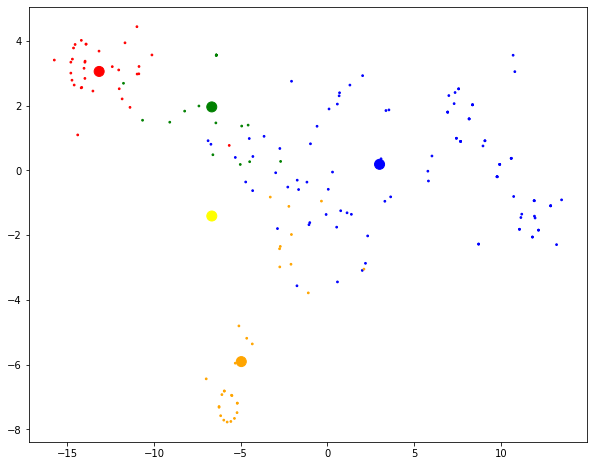

In [93]:
# tsne
import copy
emb = emb_gnn
emb = emb.cpu().detach()
mu = emb.mean(dim=0, keepdim=True)
# std = x.std(dim=0, keepdim=True)
# std[std == 0] = 1e-8
# x_norm = (x - mu) / std
emb_norm = emb - mu

# add class center of class one vs. all other classes
# emb_final = torch.cat((emb_norm, emb_norm[data.y == 0].mean(0, keepdim=True), emb_norm[data.y != 0].mean(0, keepdim=True)), dim=0)
emb_final = copy.deepcopy(emb_norm)
for select_class in range(dataset.num_classes):
    emb_final = torch.cat((emb_final, emb_norm[data.y == select_class].mean(0, keepdim=True)), dim=0)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
emb_tsne = tsne.fit_transform(emb_final)

colors = np.array(['r', 'yellow', 'g', 'b', 'orange', 'gray', 'purple'])
# center_0 = tsne.predict(x_norm[data.y == 0].mean(0))
plt.figure(figsize = (10, 8))
plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], s=[3 for _ in range(x.shape[0])] + [100] * dataset.num_classes, c=colors[data.cpu().y].tolist() + colors.tolist()[:dataset.num_classes])

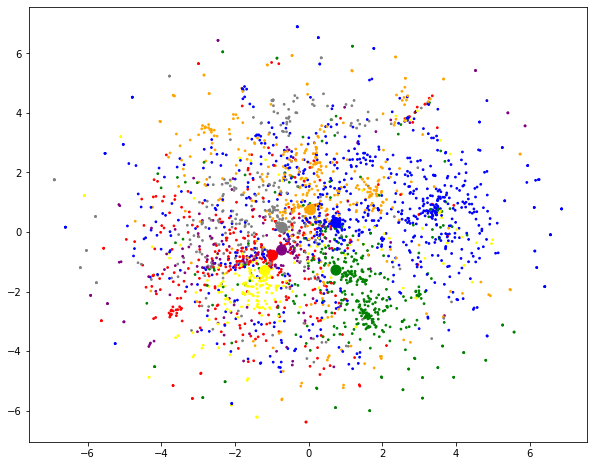

In [410]:
# tsne
x = data.cpu().x
mu = x.mean(dim=0, keepdim=True)
std = x.std(dim=0, keepdim=True)
std[std == 0] = 1e-8
# x_norm = (x - mu) / std
x_norm = x - mu

# add class center of each class
select_class = 0
x_final = copy.deepcopy(x_norm)
for select_class in range(dataset.num_classes):
    x_final = torch.cat((x_final, x_norm[data.y == select_class].mean(0, keepdim=True)), dim=0)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
x_tsne = tsne.fit_transform(x_final)

colors = np.array(['r', 'yellow', 'g', 'b', 'orange', 'gray', 'purple'])
# center_0 = tsne.predict(x_norm[data.y == 0].mean(0))
plt.figure(figsize = (10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s=[3 for _ in range(x.shape[0])] + [100] * dataset.num_classes, c=colors[data.cpu().y].tolist() + colors.tolist()[:dataset.num_classes])

280 183


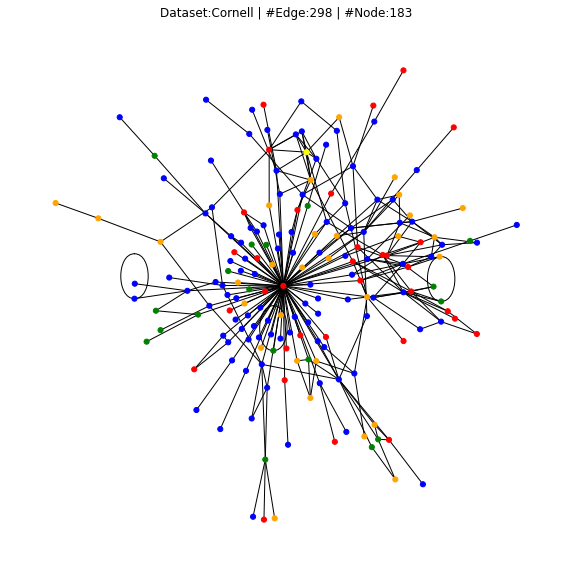

In [22]:
# plot graph structure by networkx
import networkx as nx
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_title('Dataset:{} | #Edge:{} | #Node:{}'.format(Dataset, data.num_edges, data.num_nodes))
G = nx.Graph()
G.add_nodes_from(np.arange(data.num_nodes))
G.add_edges_from(data.cpu().edge_index.transpose(0, 1).tolist())
print(G.number_of_edges(), G.number_of_nodes())
colors = np.array(['r', 'yellow', 'g', 'b', 'orange', 'gray', 'purple'])

nx.draw(G, cmap = plt.get_cmap('jet'), node_color=colors[data.y], node_size=26, ax=ax)

162 183


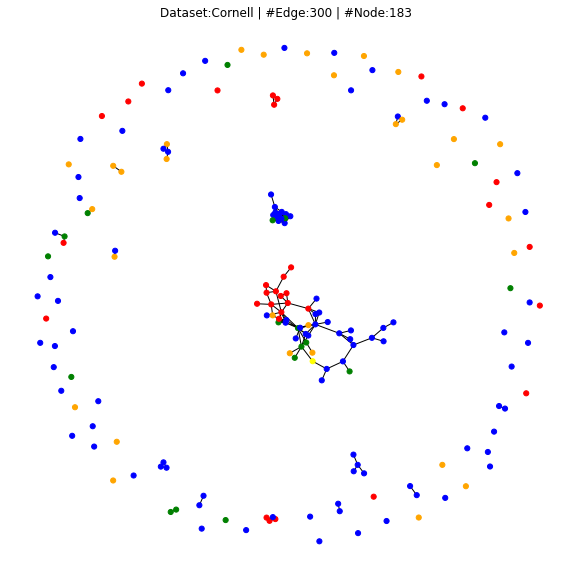

In [21]:
# plot graph structure by networkx
import networkx as nx
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_title('Dataset:{} | #Edge:{} | #Node:{}'.format(Dataset, data_modi.edge_index.shape[1], data_modi.num_nodes))
G = nx.Graph()
G.add_nodes_from(np.arange(data.num_nodes))
G.add_edges_from(data_modi.cpu().edge_index.transpose(0, 1).tolist())
print(G.number_of_edges(), G.number_of_nodes())
colors = np.array(['r', 'yellow', 'g', 'b', 'orange', 'gray', 'purple'])

nx.draw(G, pos=nx.spring_layout(G), cmap = plt.get_cmap('jet'), node_color=colors[data_modi.y], node_size=26, ax=ax)